In [356]:
import simpy
from functools import partial, wraps
import itertools
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [357]:
def patch_resource(resource, pre=None, post=None):
     """Patch *resource* so that it calls the callable *pre* before each
     put/get/request/release operation and the callable *post* after each
     operation.  The only argument to these functions is the resource
     instance.

     """
     def get_wrapper(func):
         # Generate a wrapper for put/get/request/release
         @wraps(func)
         def wrapper(*args, **kwargs):
             # This is the actual wrapper
             # Call "pre" callback
             if pre:
                 pre(resource)

             # Perform actual operation
             ret = func(*args, **kwargs)

             # Call "post" callback
             if post:
                 post(resource)

             return ret
         return wrapper

     # Replace the original operations with our wrapper
     for name in ['put', 'get', 'request', 'release']:
         if hasattr(resource, name):
             setattr(resource, name, get_wrapper(getattr(resource, name)))

def monitor(data, resource):
     """This is our monitoring callback."""
     item = (
         resource._env.now,  # The current simulation time
         resource.level,  # The level of the container
     )
     data.append(item)

In [358]:
def lngc(env, fsru, f_tank):
    """
    lngc arrives at the fsru, connects to it and starts filling
    continuously until empty.
    The level of the lngc decreases at a constant rate
    """

    # random time to get through the channel
    tic = random.randint(*T_IN_CHANNEL)
    for i in range(tic):
        yield f_tank.get(1)
    
    yield env.timeout(tic)

    t_lvl = random.choice(LNGC_CAP)
    t_send = round(t_lvl / LNGC_SENDOUT, 0)
    with fsru.request() as req:
        start = f_tank.level

        yield req

        # input the amount of LNG in the LNGC
        yield f_tank.put(t_lvl - FSRU_SENDOUT*t_send)

        # The "actual" emptying time of the LNGC
        yield env.timeout(t_send)

    print(f'before: {start}', f'now: {f_tank.level}')

def fsru_control(env, fsru, f_tank):
    """Periodically check the level of the *fuel_pump* and call the tank
    truck if the level falls below a threshold."""
    while True:
        if f_tank.level <= FSRU_OPTIM:
            # Wait for the tank truck to arrive and refuel the station
            yield env.process(lngc(env, fsru, f_tank))

        if f_tank.level > FSRU_LEVEL[0]:
            send_val = min(FSRU_SENDOUT, f_tank.level - FSRU_LEVEL[0])
            yield f_tank.get(send_val)

        yield env.timeout(1)  # Check every 1 hour

In [359]:
FSRU_LEVEL = [3300, 174e3]
FSRU_OPTIM = 3300
FSRU_SENDOUT = 1097

LNGC_CAP = [40e3, 90e3]
LNGC_SENDOUT = 1e4

T_IN_CHANNEL = [5, 33]

In [360]:
env = simpy.Environment()
# there is one fsru connection
fsru = simpy.Resource(env, 1)
f_tank = simpy.Container(env, FSRU_LEVEL[1], init=FSRU_LEVEL[1])
env.process(fsru_control(env, fsru, f_tank))

data = []
monitor = partial(monitor, data)
patch_resource(f_tank, post=monitor)  # Patches (only) this resource instance

env.run(until = 500)

before: 3291.0 now: 83418.0
before: 3268.0 now: 38880.0
before: 3290.0 now: 38902.0
before: 3284.0 now: 38896.0
before: 3277.0 now: 38889.0
before: 3286.0 now: 38898.0


In [361]:
f_lvl = [val[1] for val in data]
idx = [val[0] for val in data]

df = pd.DataFrame(
    {
        'row' : idx,
        'lvl' : f_lvl
    }
)

In [362]:
print(df)

       row       lvl
0      0.0  172903.0
1      1.0  171806.0
2      2.0  170709.0
3      3.0  169612.0
4      4.0  168515.0
..     ...       ...
472  495.0   37801.0
473  496.0   36704.0
474  497.0   35607.0
475  498.0   34510.0
476  499.0   33413.0

[477 rows x 2 columns]


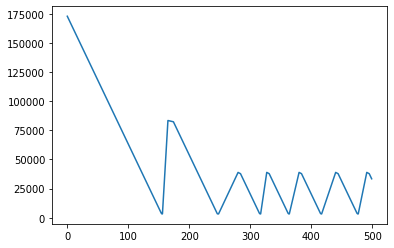

In [363]:
plt.plot(df.row, df.lvl)

In [309]:
min(df.lvl)

12925.0